Code for testing and the development of the simple bump modes scenario

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.latent_regression.scenarios import BumpInputWithRecursiveDynamicsScenario
from janelia_core.ml.latent_regression.scenarios import plot_2d_conditional_prior
from janelia_core.ml.latent_regression.scenarios import plot_2d_modes

from janelia_core.ml.latent_regression.vi import MultiSubjectVIFitter

### Parameters go here

In [3]:
n_subjects = 3
n_modes = 2
n_neuron_range = [1000, 1000]
n_dims = 2
n_smps_range = [100, 1000]
prior_std = .001
noise_range = [.01, .02]
bump_std_range = [.1, .1]

### Generate priors and subject models

In [4]:
true_mdls = BumpInputWithRecursiveDynamicsScenario(n_subjects=n_subjects, 
                                                   n_modes=n_modes, 
                                                   n_neuron_range=n_neuron_range, 
                                                   n_dims=n_dims,
                                                   prior_std=prior_std, 
                                                   noise_range=noise_range, 
                                                   bump_std_range=bump_std_range)

### View prior modes

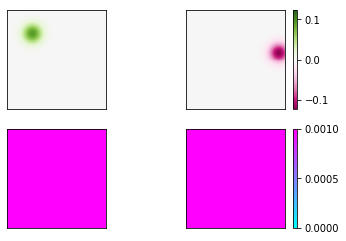

In [5]:
plot_2d_conditional_prior(true_mdls.input_u_prior)

### View modes for a given model

In [6]:
plot_s = 0

In [7]:
u = true_mdls.subject_mdls[plot_s].u[0].detach().numpy()
internal_p = true_mdls.subject_mdls[plot_s].p[1].detach().numpy()
neuron_p = true_mdls.subject_mdls[plot_s].neuron_pos.numpy()

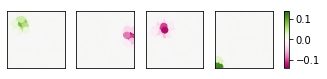

In [8]:
plot_2d_modes(modes=u, neuron_p=neuron_p)

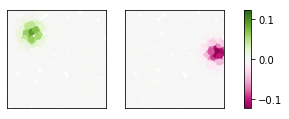

In [9]:
plot_2d_modes(modes=internal_p, neuron_p=neuron_p)

### Generate data from the models

In [10]:
n_smps = np.random.randint(n_smps_range[0], n_smps_range[1]+ 1, n_subjects)
subject_data = true_mdls.generate_random_input_data(n_smps, input_std=100)

### Fit one model use maximum likelihood

In [11]:
fit_s = 0

In [12]:
fit_data = subject_data[fit_s][0:-1]
fit_x = [t[fit_data.i_x,:] for t in fit_data.data]
fit_y = [fit_data.data[1][fit_data.i_y,:]]

In [13]:
fit_mdl = true_mdls.generate_training_subject_mdl(fit_s)

In [15]:
log = fit_mdl.fit(x=fit_x, y=fit_y, update_int=1000, max_its=3000, 
                          learning_rates=.0001, batch_size=100, send_size=100)

0: Elapsed fitting time 1.0967254638671875e-05, vl: 2.5284178, lr: 0.0001
1000: Elapsed fitting time 1.654723882675171, vl: -452.1768, lr: 0.0001
2000: Elapsed fitting time 3.1716182231903076, vl: -685.27075, lr: 0.0001
2999: Elapsed fitting time 4.959033966064453, vl: -686.2523


#### Look at fit u modes

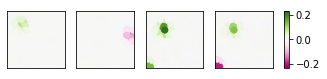

In [16]:
u_fit = fit_mdl.u[0].detach().numpy()
internal_p_fit = fit_mdl.p[1].detach().numpy()
neuron_p_fit = true_mdls.subject_mdls[fit_s].neuron_pos.detach()

plot_2d_modes(modes=u_fit, neuron_p=neuron_p_fit)

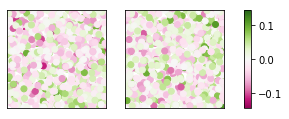

In [17]:
plot_2d_modes(modes=internal_p_fit, neuron_p=neuron_p_fit)

### Fit everything with variational inference

In [81]:
prior_dists = true_mdls.generate_fitting_priors()

In [82]:
subject_collections = [true_mdls.generate_training_collection(s_i=s_i, data=data)
                      for s_i, data in enumerate(subject_data)]

In [83]:
vi_fitter = MultiSubjectVIFitter(p_priors=prior_dists[0], u_priors=prior_dists[1], 
                                 s_collections=subject_collections)

In [88]:
logs=vi_fitter.fit(n_epochs=100, n_batches=10, update_int=2)

Epoch 0 complete.  Obj: 204256.81, LR: 0.01
Model NLLs: s_0: 87217.4921875, s_1: 35274.77734375, s_2: 81764.5546875, 
Epoch 2 complete.  Obj: 69940.555, LR: 0.01
Model NLLs: s_0: 27755.853515625, s_1: 10648.990234375, s_2: 31535.712890625, 
Epoch 4 complete.  Obj: 25947.584, LR: 0.01
Model NLLs: s_0: 9564.88671875, s_1: 3567.14990234375, s_2: 12815.546875, 
Epoch 6 complete.  Obj: 42549.254, LR: 0.01
Model NLLs: s_0: 37129.2734375, s_1: 1802.798828125, s_2: 3617.1845703125, 
Epoch 8 complete.  Obj: 26167.848, LR: 0.01
Model NLLs: s_0: 12379.029296875, s_1: 1904.94140625, s_2: 11883.876953125, 
Epoch 10 complete.  Obj: -14616.996, LR: 0.01
Model NLLs: s_0: -5966.802734375, s_1: -2700.384765625, s_2: -5949.80859375, 
Epoch 12 complete.  Obj: -20271.559, LR: 0.01
Model NLLs: s_0: -8533.86328125, s_1: -804.5244140625, s_2: -10933.169921875, 
Epoch 14 complete.  Obj: -29668.787, LR: 0.01
Model NLLs: s_0: -10501.439453125, s_1: -2398.640625, s_2: -16768.70703125, 
Epoch 16 complete.  Obj: -2

#### Look at log values

Text(0.5, 0, 'Elapsed Time')

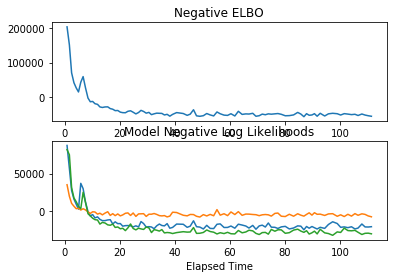

In [89]:
plt.subplot(2,1,1)
plt.plot(logs['elapsed_time'], logs['nelbo'])
plt.title('Negative ELBO')
plt.xlabel('Elapsed Time')

plt.subplot(2,1,2)
plt.plot(logs['elapsed_time'], logs['mdl_nll'])
plt.title('Model Negative Log Likelihoods')
plt.xlabel('Elapsed Time')

#### Look at fit modes for one subject

In [112]:
fit_s = 2
neuron_u_pos = true_mdls.subject_mdls[fit_s].neuron_pos

u_mn = subject_collections[fit_s].u_dists[0].form_standard_sample(
    subject_collections[fit_s].u_dists[0].sample(neuron_u_pos)).cpu().detach().numpy()

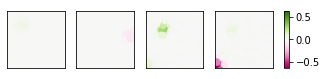

In [113]:
plot_2d_modes(modes=u_mn, neuron_p=neuron_u_pos)